# EnsembleX

Variation of mean, median, and using naive1/naive2 as a backup.
This ensembling used for Yearly data only!

**Changelog:**
- 7 Jun, adaptation to the project path (hack)
- 1 Jun, fixed a bug: a variable name was not updated for all the usage in the code caused predictions on test to be broken
- 31 May, added a check for the predictions contained at least one negative value from both hold-out and test - on test set naive1 used as an alternative
- 30 May, added kaur correlation (with potental contribution of 14K sampels)
- 29 May, added the block for making final submission (prediction testset)

In [3]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
HOME_DIR = "/".join(os.getcwd().split("/")[:-2]) # quick hack. TODO: fine a better way
# HOME_DIR = "."

## Specify datasets paths and load naive predictions

Naive predictions used as a back in cases when we don't have any better prediction for a specific row!

In [27]:
# reference for Yearly
train_path = HOME_DIR + '/datasets/M4DataSet/Yearly-train.csv' # path modifiable
train_dataset = pd.read_csv(train_path)

# predictions to ensemble
holdout_path = HOME_DIR + '/results_models/holdout/' # path modifiable
test_path = HOME_DIR + '/results_models/test/' # path modifiable

# naive for a backup ensemble
results_path = HOME_DIR + '/results_models'
naive1_holdout = pd.read_csv(os.path.join(results_path, 'naive', 'naive1_full_holdout.csv'))
naive1_test = pd.read_csv(os.path.join(results_path, 'naive', 'naive1_full_test.csv'))
naive2_holdout = pd.read_csv(os.path.join(results_path, 'naive', 'naive2_full_holdout.csv'))
naive2_test = pd.read_csv(os.path.join(results_path, 'naive', 'naive2_full_test.csv'))

# series info
m4info = pd.read_csv(HOME_DIR + '/datasets/M4-info.csv') # path modifiable

## Load Correlation method predictions with specified correlations

In [28]:
# correlation predictions
corr_info_holdout = pd.read_csv(os.path.join(results_path, 'correlations', 'TeamKaur_corr5values_full_holdout.csv'))
corr_info_test = pd.read_csv(os.path.join(results_path, 'correlations', 'TeamKaur_corr5values_test.csv'))
corr_holdout = pd.read_csv(os.path.join(results_path, 'correlations', 'TeamKaur_corr5_full_holdout.csv'))
corr_test = pd.read_csv(os.path.join(results_path, 'correlations', 'TeamKaur_corr5_test.csv'))

# filter only the highly correlation ones
def get_highcorr_data(dataset, dataset_info, group='Y', threshold=0.9999):
    filtered = dataset_info.apply(lambda r: r['id'][0]==group and r['correlation'] > threshold, axis=1)
    group_id = dataset_info[filtered]['id']
    return corr_holdout[corr_holdout['Unnamed: 0'].isin(group_id)]

# relevant correlations for yearly!
corr_holdout = get_highcorr_data(corr_holdout, corr_info_holdout, group='Y', threshold=0.999)
corr_test = get_highcorr_data(corr_test, corr_info_holdout, group='Y', threshold=0.999)

# FIXME: the correlation can be trusted directly based on the reported correlation value rather than 
# picking the correation_test instances based on the hold-out process evaluation! Currently I'm doing the former.
# thresh >0.9999 corresponds to ~ 5248 samples
# thresh >0.999 corresponds to ~ 14K samples
print("number of picked samples from correlation dataset (holdout): ", corr_holdout.shape[0])
print("number of picked samples from correlation dataset (test): ", corr_test.shape[0])

number of picked samples from correlation dataset (holdout):  14280
number of picked samples from correlation dataset (test):  14280


## Load all prediction datasets into a pool of datasets

In [29]:
# load the rest of the datasets for ensembling
holdout_datasets = []
test_datasets = []
methods_name = []

# NB: this piece of code is not flexible in the sense that the file names should have similar pattern 
# i.e. cannot load: jack_full_holdout  jack_test - should be jack_holdout and jack_test
for file in tqdm(os.listdir(holdout_path)):
    print(" loaded: ", file.rstrip("holdout.csv"))
    methods_name.append(file.rstrip("_holdout.csv"))
    holdout_ds = pd.read_csv(os.path.join(holdout_path, file))
    holdout_ds = holdout_ds[holdout_ds.iloc[:,0].apply(lambda r: r[0] == 'Y')]
    holdout_datasets.append(holdout_ds)
    test_ds = pd.read_csv(os.path.join(test_path, file.rstrip("holdout.csv") + "test.csv"))    
    test_ds = test_ds[test_ds.iloc[:,0].apply(lambda r: r[0] == 'Y')]
    test_datasets.append(test_ds)
holdout_datasets.append(corr_holdout)
test_datasets.append(corr_test)
methods_name.append('kaur_correlation')
print(" loaded: ", 'kaur_correlation')

A Jupyter Widget

 loaded:  RandomF_RandomF1_full_
 loaded:  TeamPotam_TeamPotam_Yearly_
 loaded:  Anti_arima_full_
 loaded:  RandomF_XGBoost2_full_
 loaded:  RF_damped_full_
 loaded:  TeamKaur_stupidity_full_
 loaded:  RF_arima_full_
 loaded:  Fearless_fearless5_full_
 loaded:  RF_ets_full_

 loaded:  kaur_correlation


## Measures provided by the competition

It is used on the fly to pick the best predictions per row!

In [30]:
def smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b)))


def mase(insample, y_test, y_hat_test, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])

    masep = np.mean(abs(insample[freq:] - y_hat_naive))

    return np.mean(abs(y_test - y_hat_test)) / (masep + 0.000000000000000000000000000000001)

# Ensembling Process

Procedure is as follows:
1. eliminate predictions that are worse than naive1 and naive2
2. keep preditions better than naive1 & naive2 or better than 2*naive1 or 2*naive2
3. calculate the sum of above errors for ensemble of mean, median, naive1 and naive2
4. keep track of best predictions and ensembling strategy per row
5. perform final prediction for submission

In [31]:
def load_serie_info(m4info, ts_id):
    ts_info = m4info[m4info['M4id'] == ts_id] # get m4info of this serie
    fh = ts_info['Horizon'].values[0]         # forecasting horizon
    freq = ts_info['Frequency'].values[0]     # data frequency
    return fh, freq

In [7]:
parameters = {}
results = {}
for ind in tqdm(train_dataset['V1']):
    #print(ind)
    
    ts = train_dataset[train_dataset['V1'] == ind].dropna(axis=1).values[0]
    fh, freq = load_serie_info(m4info, ind)
    y_test = ts[-fh:]
    insample = ts[-2*fh:-fh]
    
    #print(fh, freq)
    best_metrix = np.inf
    predictions = []
    errors = []
    #naive1 = np.empty((0,6))
    #naive1 = np.append(naive1, np.ones(6) * ts[-(fh+1)])
    naive1 = naive1_holdout[naive1_holdout['V1'] == ind].dropna(axis=1).values[0,1:]
    naive2 = naive2_holdout[naive2_holdout['V1'] == ind].dropna(axis=1).values[0,1:]

    naive1_err = mase(insample, y_test, naive1, freq) + smape(y_test, naive1)
    naive2_err = mase(insample, y_test, naive2, freq) + smape(y_test, naive2)
    
    # get predictions and calculate their error for further comparison
    for dataset in holdout_datasets:
        prediction = dataset[dataset.iloc[:,0] == ind].dropna(axis=1)
        if prediction.shape[0] == 0 or np.sum(prediction.values[0,1:] < 0): # ignore predictions even with one negative value
            # to avoid messing up the indices (necessary for final submission!)
            predictions.append(np.ones(6)*-1)
            errors.append(np.inf)
            continue
        prediction = prediction.values[0][1:]
        predictions.append(prediction)
        mase_err = mase(insample, y_test, prediction, freq)
        smape_err = smape(y_test, prediction)
        errors.append(mase_err + smape_err)
    predictions = np.array(predictions)
    assert predictions.shape[0] == len(errors)

    indeces_less_naive = []
    indeces_less_two_naives = []
    
    # compare errors
    for i, error in enumerate(errors):
        if error == np.inf: # a check to make sure!
            continue
        if error <= naive1_err and error <= naive2_err:
            indeces_less_naive.append(i)
        if error <= 2 * naive1_err and error <= 2 * naive2_err:
            indeces_less_two_naives.append(i)
          
    predictions_for_avg_1 = predictions[indeces_less_naive] 
    predictions_for_avg_2 = predictions[indeces_less_two_naives] 
    
    mean_preadiction_1 = np.mean(predictions_for_avg_1, axis=0)
    mean_preadiction_2 = np.mean(predictions_for_avg_2, axis=0)
    median_preadiction_1 = np.median(predictions_for_avg_1, axis=0)
    median_preadiction_2 = np.median(predictions_for_avg_2, axis=0)
    
    final_predictions = [mean_preadiction_1, mean_preadiction_2, median_preadiction_1, median_preadiction_2, naive1, naive2]
    indices = [indeces_less_naive, indeces_less_two_naives, indeces_less_naive, indeces_less_two_naives, [], []]
    method = ['mean', 'mean', 'median', 'median', 'naive1', 'naive2']
    best_error = np.inf
    best_ind = -1
    for i in range(len(final_predictions)):
        final_prediction = final_predictions[i]
        mase_err = mase(insample, y_test, final_prediction, freq)
        smape_err = smape(y_test, final_prediction)
        error = mase_err + smape_err
        if error < best_error:
            best_error = error
            best_ind = i
    results[ind] = final_predictions[best_ind]
    parameters[ind] = [indices[best_ind], method[best_ind]]

A Jupyter Widget

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [19]:
results_final_path=HOME_DIR + '/results_final'
pd.DataFrame.from_dict(results, orient='index').to_csv(os.path.join(results_final_path, 'Yearly_holdout.csv'))

## Some stats based on hold-out ensembling

A Jupyter Widget


[16951, 18902, 14766, 16810, 17017, 17134, 15540, 18444, 15106, 9954]


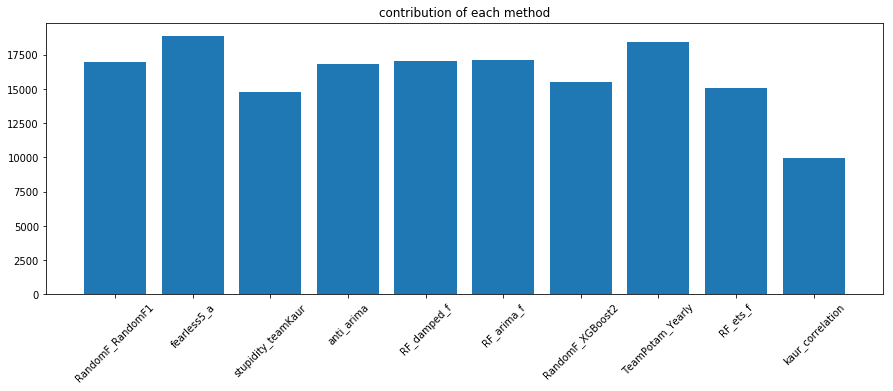

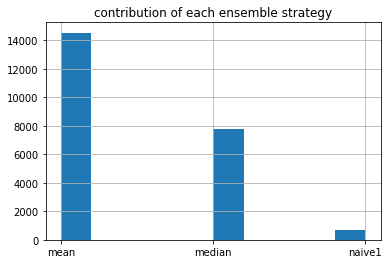

In [9]:
from matplotlib import pyplot as plt

method = [0]*len(holdout_datasets)
for ind, parameter in tqdm(parameters.items()):
    for i in parameter[0]:
        method[i] += 1
print(method)
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.bar(np.arange(0, len(method)), method)
plt.xticks(np.arange(0, len(method)), tuple(methods_name), rotation=45)
plt.title('contribution of each method')
plt.show()

params_stat = pd.DataFrame.from_dict(parameters, orient='index')
params_stat.loc[:,1].hist()
plt.title('contribution of each ensemble strategy')
plt.show()

In [10]:
# basically we expect no negative prediction!
rr = pd.DataFrame.from_dict(results, orient='index')
pp = pd.DataFrame.from_dict(parameters, orient='index')
print("number of negative predictions: \n", np.sum(rr < 0))
for neg_is in np.where(rr < 0)[0]:
    print(rr.iloc[neg_is,:].values)
    print(pp.iloc[neg_is,:].values)

number of negative predictions: 
 0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64


## Final prediction for submission

In [15]:
preds_test = {}
negative_predictions = {}

for ind, parameter in tqdm(parameters.items()):
    method = parameter[1]
    worthy_preds = parameter[0]
    
    if method == "naive1":        
        preds_test[ind] = naive1_test[naive1_test['V1'] == ind].dropna(axis=1).values[0,1:]
        continue
    elif method == "naive2":
        preds_test[ind] = naive2_test[naive1_test['V1'] == ind].dropna(axis=1).values[0,1:]
        continue

    predictions = []
    excluded_preds = []
    for i in worthy_preds:
        prediction = test_datasets[i][test_datasets[i].iloc[:,0] == ind].dropna(axis=1).values[0][1:]
        if np.sum(prediction < 0):
            excluded_preds.append(i)
            continue
        predictions.append(prediction)
    negative_predictions[ind] = excluded_preds
    predictions = np.array(predictions)
    
    if predictions.shape[0] == 0: # backup plan
        print("no good prediction!")
        preds_test[ind] = naive1_test[naive1_test['V1'] == ind].dropna(axis=1).values[0,1:]
    elif method == "mean":
        preds_test[ind] = np.mean(predictions, axis=0)
    elif method == "median":
        preds_test[ind] = np.median(predictions, axis=0)
    else:
        print("Something's wrong!!")
        assert False

A Jupyter Widget

no good prediction!
no good prediction!
no good prediction!
no good prediction!
no good prediction!
no good prediction!



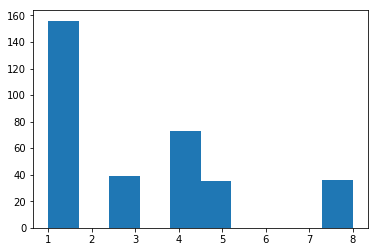

In [16]:
dataset_neg = []
for ll in negative_predictions.values():
    if ll:
        for l in ll:
            dataset_neg.append(l)
            
plt.hist(dataset_neg)
plt.show()

In [17]:
# basically we expect no negative prediction!
rr = pd.DataFrame.from_dict(preds_test, orient='index')
pp = pd.DataFrame.from_dict(parameters, orient='index')
print("number of negative predictions: \n", np.sum(rr < 0))
for neg_is in np.where(rr < 0)[0]:
    print(rr.iloc[neg_is,:].values)
    print(pp.iloc[neg_is,:].values)

number of negative predictions: 
 0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64


In [20]:
pd.DataFrame.from_dict(preds_test, orient='index').to_csv(os.path.join(results_final_path, 'Yearly.csv'))